In [21]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [22]:
import os
import pandas as pd
import numpy as np 
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.42.1
Tensorflow version is: 1.14.0


In [24]:
def invTransform(scaler, data, colName, colNames):  
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [25]:
data_dir = './GHI_dataset/cleaned_sampled_data/'
file_path = os.path.join(data_dir, 'GHI_sampled_45_minutes.csv')
data_df = pd.read_csv(file_path, index_col=0)
print("Shape of the DataFrame:", data_df.shape)
print(data_df.head())
batch_size = min(64, int(data_df.shape[0]))

Shape of the DataFrame: (29779, 16)
                           GHI       GHIcs         k    GHI_d1  GHIcs_d1  \
datetime                                                                   
2016-01-08 07:30:00  19.529172   44.045363  0.447562  0.009260  0.029134   
2016-01-08 08:15:00  28.777781  102.119213  0.306533  0.003055  0.032780   
2016-01-08 09:00:00  70.317230  187.379626  0.372109  0.005698  0.029195   
2016-01-08 09:45:00  55.284630  255.897973  0.216256  0.002613  0.021157   
2016-01-08 10:30:00  53.889504  299.952497  0.179476  0.002406  0.011316   

                             k_d1    GHI_d2      GHIcs_d2          k_d2  \
datetime                                                                  
2016-01-08 07:30:00 -9.347908e-05  0.000019  5.355476e-06  5.147700e-07   
2016-01-08 08:15:00 -7.241380e-05 -0.000005  3.288762e-07 -4.739228e-08   
2016-01-08 09:00:00 -3.344239e-06 -0.000010 -2.420594e-06 -4.069912e-08   
2016-01-08 09:45:00 -6.626004e-06  0.000024 -3.395284e-0

In [26]:
nPrevSteps = 5
polynomialAug = 5
basicFeatures = ['GHI', 'GHIcs', 'k']

In [27]:
nFeatures = len(basicFeatures)
X = data_df.loc[:, basicFeatures]
print("Array X", X.head())

Array X                            GHI       GHIcs         k
datetime                                            
2016-01-08 07:30:00  19.529172   44.045363  0.447562
2016-01-08 08:15:00  28.777781  102.119213  0.306533
2016-01-08 09:00:00  70.317230  187.379626  0.372109
2016-01-08 09:45:00  55.284630  255.897973  0.216256
2016-01-08 10:30:00  53.889504  299.952497  0.179476


In [28]:
poly = PolynomialFeatures(polynomialAug)
X_poly = poly.fit_transform(X)
colNames = poly.get_feature_names_out(X.columns)
#print("Augmented Column Names", colNames)

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_poly)
scaled = scaler.transform(X_poly)
scaled = pd.DataFrame(scaled, columns = colNames, index = data_df.index)
scaled = scaled.drop("1", axis=1)
nFeatureColumns = scaled.shape[1]
print("Data Frame: ", scaled.head())
print("Data Frame Feature Columns: ", nFeatureColumns)

Data Frame:                            GHI     GHIcs         k     GHI^2  GHI GHIcs  \
datetime                                                                 
2016-01-08 07:30:00  0.017932  0.016525  0.027860  0.000400   0.000923   
2016-01-08 08:15:00  0.027482  0.084919  0.018925  0.000874   0.003365   
2016-01-08 09:00:00  0.070375  0.185331  0.023080  0.005244   0.015390   
2016-01-08 09:45:00  0.054852  0.266026  0.013205  0.003239   0.016531   
2016-01-08 10:30:00  0.053412  0.317910  0.010875  0.003078   0.018900   

                        GHI k   GHIcs^2   GHIcs k       k^2     GHI^3  ...  \
datetime                                                               ...   
2016-01-08 07:30:00  0.000657  0.001346  0.018009  0.000803  0.000008  ...   
2016-01-08 08:15:00  0.000663  0.012342  0.029977  0.000377  0.000026  ...   
2016-01-08 09:00:00  0.001973  0.044317  0.069651  0.000555  0.000380  ...   
2016-01-08 09:45:00  0.000900  0.083662  0.054796  0.000187  0.000185  ...   


In [30]:
train_test_df = pd.DataFrame()
for i in range(0, nPrevSteps+1, 1):
    title = scaled.columns + 't(-' + str(i) + ')'
    temp = scaled.shift(periods = i)
    temp.columns = title
    train_test_df = pd.concat([train_test_df, temp], axis=1)

print("Data Frame: ", train_test_df.head())
train_test_df = train_test_df.dropna()

Data Frame:                       GHIt(-0)  GHIcst(-0)    kt(-0)  GHI^2t(-0)  \
datetime                                                          
2016-01-08 07:30:00  0.017932    0.016525  0.027860    0.000400   
2016-01-08 08:15:00  0.027482    0.084919  0.018925    0.000874   
2016-01-08 09:00:00  0.070375    0.185331  0.023080    0.005244   
2016-01-08 09:45:00  0.054852    0.266026  0.013205    0.003239   
2016-01-08 10:30:00  0.053412    0.317910  0.010875    0.003078   

                     GHI GHIcst(-0)  GHI kt(-0)  GHIcs^2t(-0)  GHIcs kt(-0)  \
datetime                                                                      
2016-01-08 07:30:00        0.000923    0.000657      0.001346      0.018009   
2016-01-08 08:15:00        0.003365    0.000663      0.012342      0.029977   
2016-01-08 09:00:00        0.015390    0.001973      0.044317      0.069651   
2016-01-08 09:45:00        0.016531    0.000900      0.083662      0.054796   
2016-01-08 10:30:00        0.018900    0.00

In [31]:
title_0 = scaled.columns + 't(-' + str(0) + ')'
X = train_test_df.drop(title_0, axis = 1).values
y = train_test_df['GHIt(-0)'].values
print("Data Frame: ", X.shape)

Data Frame:  (29774, 275)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
X_train_r = X_train.reshape((X_train.shape[0], nPrevSteps, nFeatureColumns))
X_validation_r = X_validation.reshape((X_validation.shape[0], nPrevSteps, nFeatureColumns))
X_test_r = X_test.reshape((X_test.shape[0], nPrevSteps, nFeatureColumns))

print("Shapes (X_train_R, X_validation_r, X_test_R)", X_train_r.shape, X_validation_r.shape, X_test_r.shape)

Shapes (X_train_R, X_validation_r, X_test_R) (23819, 5, 55) (2977, 5, 55) (2978, 5, 55)


In [33]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_r.shape[1], X_train_r.shape[2])))
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_r.shape[1], X_train_r.shape[2]))) 
model.add(LSTM(64, return_sequences=False, input_shape=(X_train_r.shape[1], X_train_r.shape[2])))
model.add(Dense(1))

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 0, patience=10, restore_best_weights=True)
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train_r, y_train, epochs=5, validation_split=0.2, batch_size=32, callbacks=[es], verbose=1, shuffle = False)

Train on 19055 samples, validate on 4764 samples
Epoch 1/5
19055/19055 [==============================] - 14s 725us/sample - loss: 0.0113 - val_loss: 0.0113
Epoch 2/5
19055/19055 [==============================] - 10s 519us/sample - loss: 0.0074 - val_loss: 0.0092
Epoch 3/5
19055/19055 [==============================] - 10s 524us/sample - loss: 0.0071 - val_loss: 0.0095
Epoch 4/5
19055/19055 [==============================] - 10s 535us/sample - loss: 0.0069 - val_loss: 0.0099
Epoch 5/5
19055/19055 [==============================] - 11s 570us/sample - loss: 0.0068 - val_loss: 0.0105


In [35]:
y_pred = model.predict(X_test_r)

print("Shape of Y_Pred: ", y_pred.shape)
print("Shape of Y_Test: ", y_test.shape)

y_pred_inv = invTransform(scaler, y_pred, 'GHI', colNames)
y_test_inv = invTransform(scaler, y_test, 'GHI', colNames)

print("Shape of Y_Pred_inv: ", y_pred.shape)
print("Shape of Y_test_inv: ", y_test.shape)

Shape of Y_Pred:  (2978, 1)
Shape of Y_Test:  (2978,)
Shape of Y_Pred_inv:  (2978, 1)
Shape of Y_test_inv:  (2978,)


In [36]:
mse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
nrmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)) / np.mean(y_test_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
nmae = mean_absolute_error(y_test_inv, y_pred_inv) / np.mean(y_test_inv) 
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {mse}, nRMSE: {nrmse}, MAE: {mae}, nMAE: {nmae}, R2: {r2}')

RMSE: 108.03011579714392, nRMSE: 0.3004985124954602, MAE: 86.3961715414481, nMAE: 0.2403211441729672, R2: 0.8198629883534517


In [37]:
sample_size = 100
subset_size = 100
colNames = colNames[1:]
random_indices = np.random.choice(X_train_r.shape[0], size=sample_size, replace=False)
X_train_sample = X_train_r[random_indices]

indices = np.random.choice(X_test_r.shape[0], subset_size, replace=False)
X_test_r_subset = X_test_r[indices]

In [38]:
explainer = shap.DeepExplainer(model, X_train_sample)
shap_values_subset = explainer.shap_values(X_test_r_subset)

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_subset[0][0][0], colNames)

In [40]:
print(np.asarray(shap_values_subset).shape)
print(np.asarray(X_test_r_subset).shape)

(1, 100, 5, 55)
(100, 5, 55)


In [42]:
shap_values_to_plot = np.squeeze(shap_values_subset)
n_samples = X_test_r_subset.shape[0]
shap_values_flattened = shap_values_to_plot.reshape(n_samples, -1)
X_test_r_flattened = X_test_r_subset.reshape(n_samples, -1)
feature_names_expanded = [f"{name}_t{t+1}" for t in range(X_test_r_subset.shape[1]) for name in colNames]

print("Shape of shap_values_flattened:", shap_values_flattened.shape)
print("Shape of X_test_r_flattened:", X_test_r_flattened.shape)

Shape of shap_values_flattened: (100, 275)
Shape of X_test_r_flattened: (100, 275)


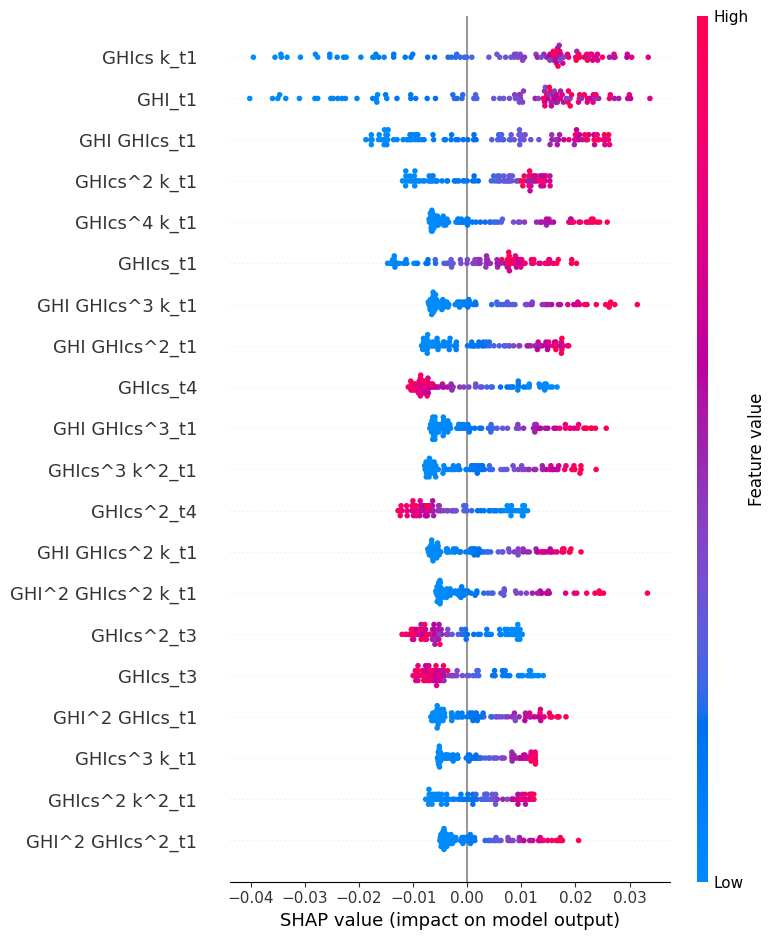

In [43]:
shap.summary_plot(shap_values_flattened, X_test_r_flattened, feature_names_expanded)

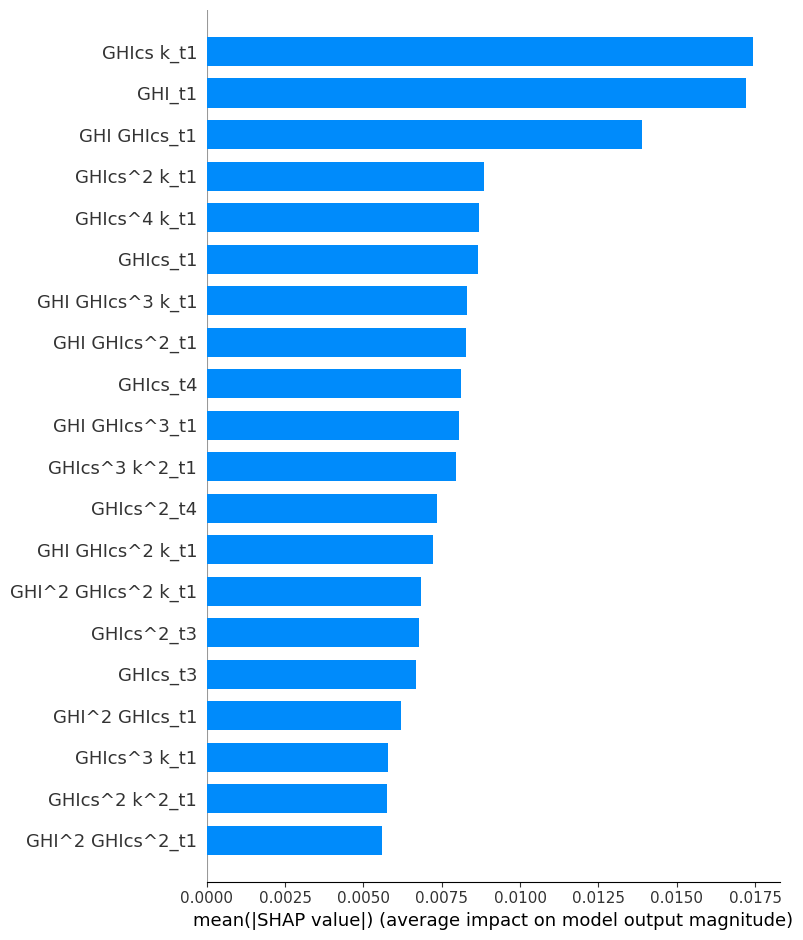

In [44]:
shap.summary_plot(shap_values_flattened, X_test_r_flattened, plot_type="bar", feature_names = feature_names_expanded)